# Exercice 3

## Load data from exercice 2

In [ ]:
import pandas as pd
df_fraud = pd.read_csv('df_fraud_filtered_imputed_encoded_reduced.csv')

## Preprocessing

In [2]:
from sklearn.model_selection import train_test_split
df_fraud_train, df_fraud_test = train_test_split(df_fraud, test_size=0.2, random_state=42)

In [3]:
# Count the number of 0 et 1 in the training set
print(df_fraud_train['isFraud'].value_counts())

isFraud
0.0    456011
1.0     16421
Name: count, dtype: int64


In [4]:
# Keep 15000 of each
df_fraud_train_0 = df_fraud_train[df_fraud_train['isFraud'] == 0].sample(n=15000, random_state=42)
df_fraud_train_1 = df_fraud_train[df_fraud_train['isFraud'] == 1].sample(n=15000, random_state=42)
df_fraud_train = pd.concat([df_fraud_train_0, df_fraud_train_1])

In [5]:
df_fraud_train_input = df_fraud_train.drop('isFraud', axis=1)
df_fraud_train_output = df_fraud_train['isFraud']

Linear regression, Ridge et Lasso are usually not models of classification so to use them as classificatio models, we decide to classificate as 1 if the output predicted is more than 0.5 and 0 else.

## Training

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV

grid_knn = {
    'n_neighbors' : [k for k in range(1, 50)]
}

grid_lr = {}

grid_ridge = {
    'alpha' : [1e-9, 1e-6, 1e-3, 1, 10, 100, 1000],
    'max_iter' : [10, 100, 1000, 10000, 100000, 1000000]
}

grid_lasso = {
    'alpha' : [1e-9, 1e-6, 1e-3, 1, 10, 100, 1000],
    'max_iter' : [10, 100, 1000, 10000, 100000, 1000000]
}

grid_LogReg = {
    'penalty': ['l2'],
    'C': [1e-9, 1e-6, 1e-3, 1, 100, 1000, 10000],
    'max_iter': [10, 100, 1000, 10000, 100000]
}

models_name = ['K-NN (roc-auc)', 'K-NN (default)', 'Linear regression', 'Ridge (roc-auc)', 'Ridge (default)', 'Lasso (roc-auc)', 'Lasso (default)', 'Logistic Regression (roc-auc)', 'Logistic Regression (default)']
grids = [grid_knn, grid_knn, grid_lr, grid_ridge, grid_ridge, grid_lasso, grid_lasso, grid_LogReg, grid_LogReg]
models = [
    GridSearchCV(KNeighborsClassifier(), grid_knn, cv=5, n_jobs=-1, scoring='roc_auc'),
    GridSearchCV(KNeighborsClassifier(), grid_knn, cv=5, n_jobs=-1),
    GridSearchCV(LinearRegression(), grid_lr, cv=5, n_jobs=-1),
    GridSearchCV(Ridge(), grid_ridge, cv=5, n_jobs=-1, scoring='roc_auc'),
    GridSearchCV(Ridge(), grid_ridge, cv=5, n_jobs=-1),
    GridSearchCV(Lasso(), grid_lasso, cv=5, n_jobs=-1, scoring='roc_auc'),
    GridSearchCV(Lasso(), grid_lasso, cv=5, n_jobs=-1),
    GridSearchCV(LogisticRegression(), grid_LogReg, cv=5, n_jobs=-1, scoring='roc_auc'),
    GridSearchCV(LogisticRegression(), grid_LogReg, cv=5, n_jobs=-1)
]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame(columns=["Model", "Precision", "Recall", "f1-score", "AUC"])

for i, (model_name, model, grid) in enumerate(zip(models_name, models, grids)):
    print(f"Training {model_name}")
    model.fit(df_fraud_train_input, df_fraud_train_output)
    print(f"Best parameters: {model.best_params_}")
    y_pred = model.predict(df_fraud_test.drop('isFraud', axis=1))
    if model_name in {'Linear regression', 'Ridge (roc-auc)', 'Ridge (default)', 'Lasso (roc-auc)', 'Lasso (default)'}:
        y_pred = [1 if y > 0.5 else 0 for y in y_pred]
    results.loc[i] = [model_name, f"{precision_score(df_fraud_test['isFraud'], y_pred):.3f}", f"{recall_score(df_fraud_test['isFraud'], y_pred):.3f}", f"{f1_score(df_fraud_test['isFraud'], y_pred):.3f}", f"{roc_auc_score(df_fraud_test['isFraud'], y_pred):.3f}"]

In [8]:
for model_name, model in zip(models_name, models):
    print(f"Best parameters for {model_name}: {model.best_params_}")

Best parameters for K-NN (roc-auc): {'n_neighbors': 2}
Best parameters for K-NN (default): {'n_neighbors': 1}
Best parameters for Linear regression: {}
Best parameters for Ridge (roc-auc): {'alpha': 1e-09, 'max_iter': 10}
Best parameters for Ridge (default): {'alpha': 1, 'max_iter': 10}
Best parameters for Lasso (roc-auc): {'alpha': 1e-09, 'max_iter': 10}
Best parameters for Lasso (default): {'alpha': 1e-06, 'max_iter': 10}
Best parameters for Logistic Regression (roc-auc): {'C': 1000, 'max_iter': 100000, 'penalty': 'l2'}
Best parameters for Logistic Regression (default): {'C': 1000, 'max_iter': 100000, 'penalty': 'l2'}


In [9]:
print(results.to_string(index=False))

                        Model Precision Recall f1-score   AUC
               K-NN (roc-auc)     0.068  0.439    0.118 0.607
               K-NN (default)     0.056  0.667    0.104 0.626
            Linear regression     0.096  0.729    0.170 0.737
              Ridge (roc-auc)     0.096  0.729    0.170 0.737
              Ridge (default)     0.097  0.729    0.170 0.737
              Lasso (roc-auc)     0.096  0.731    0.170 0.738
              Lasso (default)     0.096  0.731    0.170 0.738
Logistic Regression (roc-auc)     0.084  0.614    0.149 0.683
Logistic Regression (default)     0.084  0.614    0.149 0.683


## Results

Every model has a low precision because the repartition of the 0 & 1 in the target field is unbalanced.  
Let's see the confusion matrices.

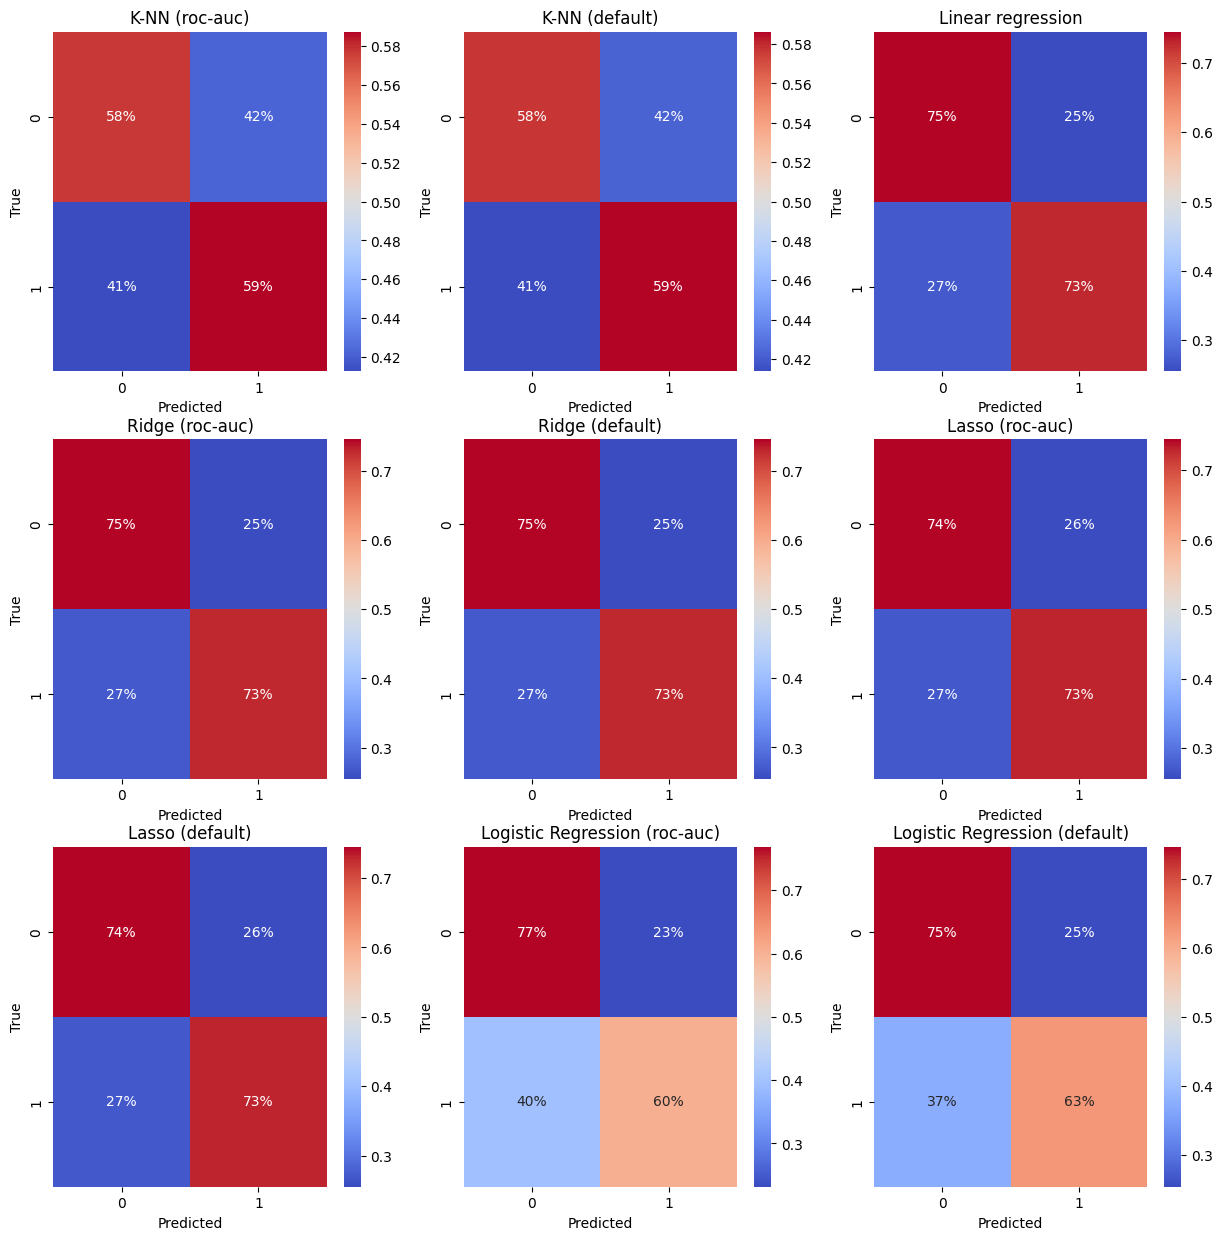

In [12]:
# Afficher les matrices de confusion en subplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, (model_name, model) in enumerate(zip(models_name, models)):
    y_pred = model.predict(df_fraud_test.drop('isFraud', axis=1))
    if model in {best_lr, best_ridge_roc, best_ridge_default, best_lasso_roc, best_lasso_default}:
        y_pred = [1 if y > 0.5 else 0 for y in y_pred]
    cm = confusion_matrix(df_fraud_test['isFraud'], y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.0%', ax=axes[i//3, i%3], cmap='coolwarm')
    axes[i//3, i%3].set_title(model_name)
    axes[i//3, i%3].set_xlabel('Predicted')
    axes[i//3, i%3].set_ylabel('True')
plt.show()

The confusion matrix are quite similar.  
Every model has quite the same results sothe easist way to choose is to choose the simplest model. That's why we can choose the Linear regression.

NB : The precision of the model is very low so the regression can be inexact. The prediction of this fraud is a difficult task and require more time of study to find the parameters and models.